# Load best model and run on test set


In [1]:
import os, sys, torch, numpy as np
import matplotlib.pyplot as plt
from pathlib import Path
from sklearn.metrics import ConfusionMatrixDisplay, roc_curve, auc

os.chdir('/Users/devaguru/Kidney Stone CNN/kidney-stone-cnn')
sys.path.insert(0, '.')

from src.data.datamodule import KidneyStoneDataModule
from src.models.efficientnet import KidneyStoneClassifier
from src.training.metrics import compute_metrics

device = torch.device('mps' if torch.backends.mps.is_available() else 'cpu')

# Load best model
model = KidneyStoneClassifier().to(device)
model.load_state_dict(torch.load('checkpoints/best_model.pth', map_location=device))
model.eval()

# Load test set
dm = KidneyStoneDataModule(batch_size=32, num_workers=0)
dm.setup()
test_loader = dm.test_loader()

# Collect predictions
all_labels, all_probs = [], []
with torch.no_grad():
    for imgs, labels in test_loader:
        logits = model(imgs.to(device))
        probs  = torch.softmax(logits, dim=1)[:, 1]
        all_labels.extend(labels.numpy())
        all_probs.extend(probs.cpu().numpy())

metrics = compute_metrics(all_labels, all_probs)
print('=== TEST SET RESULTS ===')
for k, v in metrics.items(): print(f'  {k}: {v}')



[train] Loaded 8680 images
  stone=952  no_stone=7728
[val] Loaded 1862 images
  stone=201  no_stone=1661
[test] Loaded 1904 images
  stone=224  no_stone=1680
=== TEST SET RESULTS ===
  sensitivity: 1.0
  specificity: 0.9917
  precision: 0.9412
  f2_score: 0.9877
  auc_roc: 1.0
  tp: 224
  fp: 14
  tn: 1666
  fn: 0


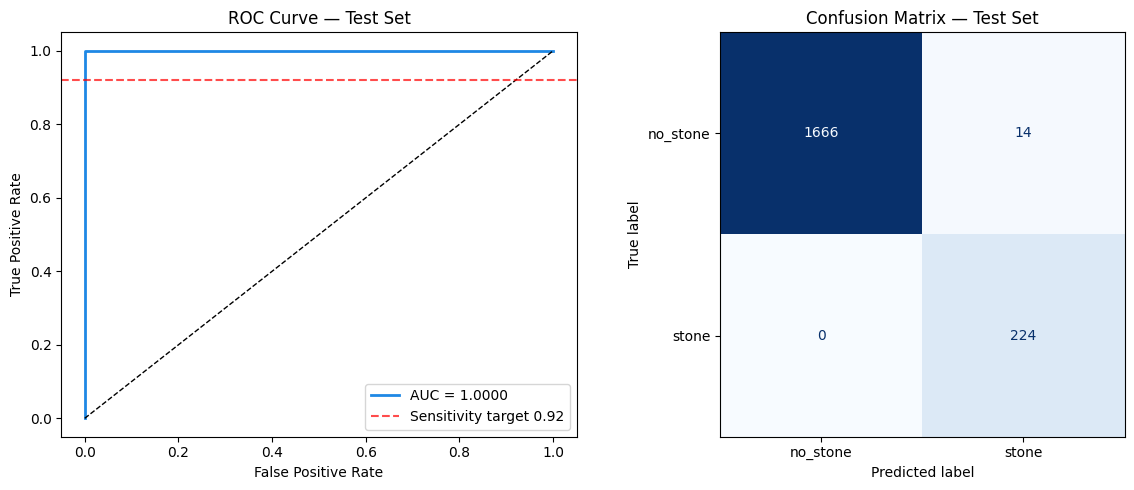

In [2]:
fig, axes = plt.subplots(1, 2, figsize=(12, 5))

# ROC Curve
fpr, tpr, _ = roc_curve(all_labels, all_probs)
roc_auc = auc(fpr, tpr)
axes[0].plot(fpr, tpr, color='#1E88E5', lw=2, label=f'AUC = {roc_auc:.4f}')
axes[0].plot([0,1],[0,1],'k--',lw=1)
axes[0].axhline(y=0.92, color='red', linestyle='--', alpha=0.7, label='Sensitivity target 0.92')
axes[0].set_xlabel('False Positive Rate'); axes[0].set_ylabel('True Positive Rate')
axes[0].set_title('ROC Curve — Test Set'); axes[0].legend()

# Confusion Matrix
preds = (np.array(all_probs) >= 0.5).astype(int)
cm_disp = ConfusionMatrixDisplay.from_predictions(
    all_labels, preds,
    display_labels=['no_stone','stone'],
    ax=axes[1], colorbar=False, cmap='Blues'
)
axes[1].set_title('Confusion Matrix — Test Set')
plt.tight_layout()
plt.savefig('data/labels/label_verification/test_results.png', dpi=120)
plt.show()

